# Training the sentiment price prediction model

## 0. Setup

Run `$ bash setup.sh` to set up environments and download data.

In [ ]:
# setup environment
!bash setup.sh

In [ ]:
# You can also set up the environment manually:
!conda create --name sent_env --file requirements.txt

# --or--
# !conda conda env create -f environment.yml

!mkdir -p ./data

# then download the sql files:
!gdown https://drive.google.com/file/d/1YG_AQIbcY2Mi-bKMLN1hff66jDBFeh4O/view?usp=sharing -O ./data/spx_news_sentiment_fundamental.db
!gdown https://drive.google.com/file/d/1C49ElctSD0hPsukQTkioneA7PeWBlMfe/view?usp=sharing -O ./data/spx_news_sentiment_price.db

## 1. Loading data

A dataset class has been implemented already. 

This uses the iterable style of the `Dataset` class.

Initiate the BaseDataset class by passing a Config object, and wrap the kwargs
into the Config object. 

When calling the `__iter__` method using `for data in dataset`, a triple will be returned `(x1, x2, y)`. x1 is the sentiment/price data, x2 is the past financial data up until the train data time, and y is the share price performance during the look_forward period (defaul 5 days, or a trading week). 

The `forward()` method needs to take in (x1, x2), as x2 carries information about the stock's fundamentals and type, but is of a different dimension as x1. An autoencoder model has been implemented and trained to convert the different dimensions of x2 into the same hidden dimensions (and is also useful for dimensionality reduction).

Note x1 and x2 are scaled to between -1 and 1. 

In [11]:
from datasets.datasets import BaseDataset
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from utils import Config

train_config = Config(mode='train', look_back=100, look_forward=5, num_workers=64)
test_config = Config(mode='test', look_back=100, look_forward=5, num_workers=64)
train_dataset = BaseDataset(config=train_config)
test_dataset = BaseDataset(config=test_config)

## 2. Train autoencoder

In [12]:
from models.autoencoder import AutoEncoder
input_dims = (88, 50)
hidden_dims = (2, )
config = Config(input_dims=input_dims, hidden_dims=hidden_dims, padding=-1.)
model = AutoEncoder(config)
print(model)

AutoEncoder(
  (LSTM_encoder): LSTM(50, 10)
  (Conv1D_encoder): Conv1d(88, 88, kernel_size=(3,), stride=(1,))
  (MaxPool1D_encoder): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Dense_encoder): Linear(in_features=352, out_features=2, bias=True)
  (Dense_decoder): Linear(in_features=2, out_features=352, bias=True)
  (MaxUnpool1D_decoder): MaxUnpool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (DeConv1D_decoder): ConvTranspose1d(88, 88, kernel_size=(3,), stride=(1,))
  (LSTM_decoder): LSTM(10, 50)
)


### 2.1 Train loop

In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
import torch
from utils import padding
from torch.utils.tensorboard import SummaryWriter
import os

lr = 5e-4
epoches = 50
run_no = 4

RUNNAME = f"{run_no}; lr={lr}; epoch={epoches}"
SAVEPATH = f"./runs/{RUNNAME}"

os.makedirs(SAVEPATH, exist_ok=True)

writer = SummaryWriter(f'./logs/autoencoder{RUNNAME}')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epoches):
    running_loss = 0.
    for data in train_dataset:
        optimizer.zero_grad()
        _, x2, _ = data
        output, _ = model(x2)
        output = padding(output, direction='left', pad_value=-1., 
            repeat=input_dims[-1] - output.shape[-1])
        x2 = padding(x2, direction='left', pad_value=-1.,
            repeat=input_dims[-1] - x2.shape[-1])
        loss = criterion(output, x2)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    writer.add_scalar('loss', running_loss / (len(train_dataset) + 
        len(test_dataset)), epoch)
    if epoch % 5 == 0:
        torch.save(dict(epoch=epoch,
            model_state_dict=model.state_dict(),
            optimizer_state_dict=optimizer.state_dict(),
            loss=loss),
            os.path.join(SAVEPATH, f"checkpoint_{epoch}.pt")
            )



In [14]:
model(x2)[0]

tensor([[-0.6420, -0.6420, -0.6420,  ..., -0.6407, -0.6411, -0.6411],
        [-0.7461, -0.7461, -0.7461,  ..., -0.7447, -0.7446, -0.7448],
        [-0.7595, -0.7595, -0.7595,  ..., -0.7589, -0.7590, -0.7590],
        ...,
        [-0.7616, -0.7616, -0.7616,  ..., -0.6417, -0.6415, -0.6416],
        [-0.7616, -0.7616, -0.7616,  ..., -0.7452, -0.7447, -0.7449],
        [-0.7616, -0.7616, -0.7616,  ...,  0.6351,  0.6394,  0.6389]],
       dtype=torch.float64, grad_fn=<TanhBackward0>)

### 2.2 Run inference on the autoencoder

In [23]:
model(next(train_dataset.load_ticker_data("AAPL", mode='train'))[1])[1]

tensor([-0.9682,  0.6428], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [24]:
model(next(test_dataset.load_ticker_data("AAPL", mode='test'))[1])[1]

tensor([-0.9999, -0.8178], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [16]:
plot_data = {}
for ticker in test_dataset.tickers:
    loc = model(next(test_dataset.load_ticker_data(ticker, mode='test'))[1])[1].detach().numpy()
    plot_data[ticker] = loc
plot_data = pd.DataFrame(plot_data)

In [20]:
plot_data.sort_values([0, 1], axis=1).T.head(50)

,0,1
GIS,-1.000000,-0.997127
AIG,-1.000000,-0.996227
DIS,-1.000000,-0.996248
BEN,-1.000000,-0.995145
CLX,-1.000000,-0.994877
ABT,-1.000000,-0.994930
CTAS,-1.000000,-0.994849
APD,-1.000000,-0.994802
CSX,-1.000000,-0.994745
BDX,-1.000000,-0.994839


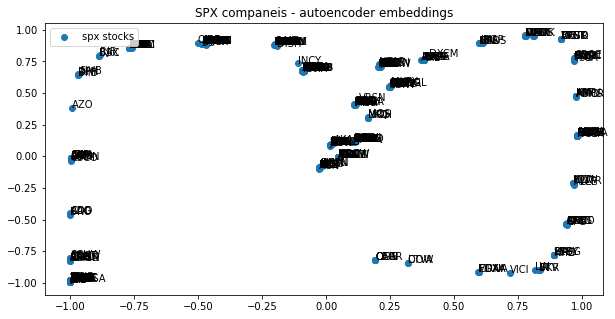

In [18]:
import matplotlib.pyplot as plt
import numpy as np
f, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(plot_data.iloc[0,], 
    plot_data.iloc[1,],
    label='spx stocks')
for ticker, (x, y) in plot_data.items():
    ax.annotate(ticker, (x, y))
ax.legend()
ax.set(title="SPX companeis - autoencoder embeddings")
plt.show()

### 2.3 Loading the pretrained autoencoder

In [ ]:
!mkdir -p ./runs/checkpoints/
!gdown https://drive.google.com/file/d/13pQb8heOYzLbniJZG4GuJNfWYUnwJDxJ/view?usp=sharing -O ./runs/checkpoint/autoencoder.pt